In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

from dask.distributed import Client
from dask_cuda import LocalCUDACluster

from ase.build import bulk
from abtem import FrozenPhonons, SMatrix, Potential, GridScan, AnnularDetector

os.environ["MKL_NUM_THREADS"] = "1"

In [3]:
client = Client()

In [4]:
client

Client Scheduler: tcp://127.0.0.1:53112 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 31.93 GiB


In [5]:
atoms = bulk('Si', 'diamond', a=5.43, cubic=True)
atoms *= (3, 3, 3)

In [6]:
# number of plane waves in each chunk
plane_wave_chunks = 32

# partioning of the griscan. The scattering matrix will be reduced in similarly partitioned chunks. Should be equal to or greater than the interpolation.
scan_partitions = (3, 3)

# Number of positions per reduction operation (single call to np.tensordot), 
# A large value reduces the number of required iterations in Python, but also increases the total number of FLOPS required
positions_per_reduction = 300

# Maximum number of scattering matrices in memory at any point
max_concurrent_s_matrices = 6

frozen_phonons = FrozenPhonons(atoms, 6, {'Si': .1})

potential = Potential(frozen_phonons, 
                      gpts=768,
                      device='cpu', 
                      projection='infinite', 
                      slice_thickness=.5)

probe = SMatrix(energy=200e3, semiangle_cutoff=20, device='cpu', chunks=plane_wave_chunks, interpolation=3, max_concurrent=max_concurrent_s_matrices)

scan = GridScan()

detectors = AnnularDetector(50, 150, ensemble_mean=False)

measurement = probe.scan(scan, 
                         detectors, 
                         potential,
                         scan_partitions=scan_partitions, 
                         positions_per_reduction=positions_per_reduction, 
                         lazy=True)


In [7]:
probe.build(lazy=True).array # just for showing the scattering matrix size

dask.array<concatenate, shape=(61, 768, 768), dtype=complex64, chunksize=(31, 768, 768), chunktype=numpy.ndarray>

<AxesSubplot:>

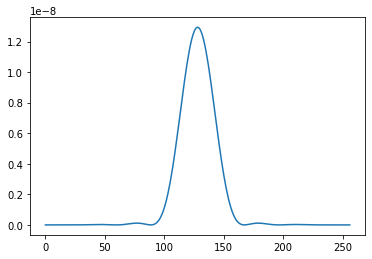

In [9]:
probe.profile().show()

In [10]:
%%time
measurement.compute()

Wall time: 57.9 s


(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x21258683880>)

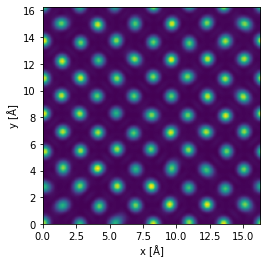

In [12]:
measurement.interpolate(.1).show()